In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.8 MB/s eta 0:00:00


In [137]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import urllib.request
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [138]:
# download the data
url = f"https://downloads.psl.noaa.gov/Datasets/ghcncams/air.mon.mean.nc"
savename = url.split("/")[-1]
urllib.request.urlretrieve(url, savename)

('air.mon.mean.nc', <http.client.HTTPMessage at 0x7ef896719cd0>)

In [140]:
# load dataset
data = xr.open_dataset(savename)
TA = data["air"] - 273.15  # convert from kelvin to celsius
time = TA.time.sel(time=slice("1990", "2020")) # time slice to the selected time frame
TA = TA.sel(time=time)

# Step 1: compute global mean temperature (area-weighted and unweighted)

In [141]:
# compute means for unweighted approaches
annual_mean_unweighted = TA.groupby('time.year').mean(dim='time').mean(dim=('lat', 'lon'))

# compute means for weighted approaches
weights = np.cos(np.deg2rad(TA.lat))  # area weights based on latitude
annual_mean_weighted = TA.groupby('time.year').mean(dim='time').weighted(weights).mean(dim=('lat', 'lon'))

# Step 2: plot time series

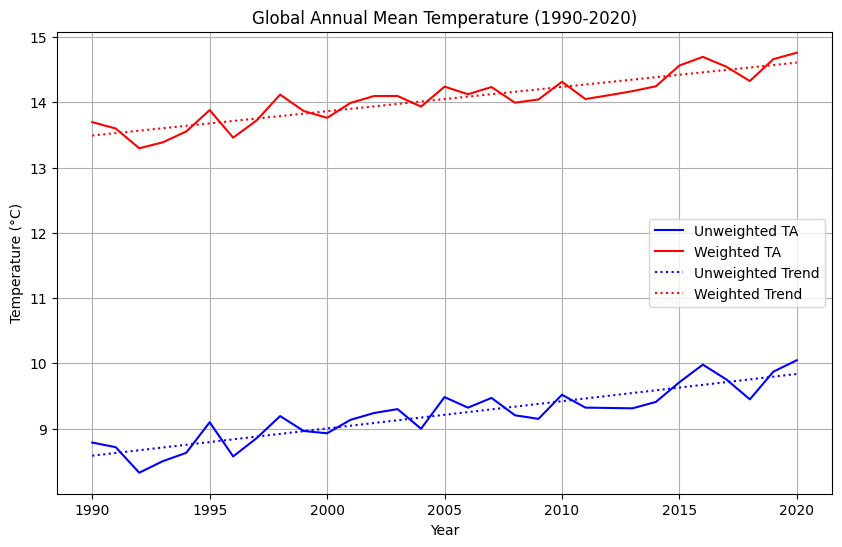

In [142]:
# extract the years for axis label
years = annual_mean_unweighted.year

# plotting
plt.figure(figsize=(10, 6))
plt.plot(years, annual_mean_unweighted, label='Unweighted TA', color='blue', linestyle='-')
plt.plot(years, annual_mean_weighted, label='Weighted TA', color='red', linestyle='-')

# calculate linear regression for unweighted data
unweighted_trend = linregress(years, annual_mean_unweighted)
slope_unweighted = unweighted_trend.slope
intercept_unweighted = unweighted_trend.intercept

# calculate linear regression for weighted data
weighted_trend = linregress(years, annual_mean_weighted)
slope_weighted = weighted_trend.slope
intercept_weighted = weighted_trend.intercept

# plot the trend lines
plt.plot(years, slope_unweighted * years + intercept_unweighted,
         color='blue', linestyle=':', label='Unweighted Trend')
plt.plot(years, slope_weighted * years + intercept_weighted,
         color='red', linestyle=':', label='Weighted Trend')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Global Annual Mean Temperature (1990-2020)')
plt.legend()
plt.grid()
plt.show()

# Step 3: 31-year mean temperature maps

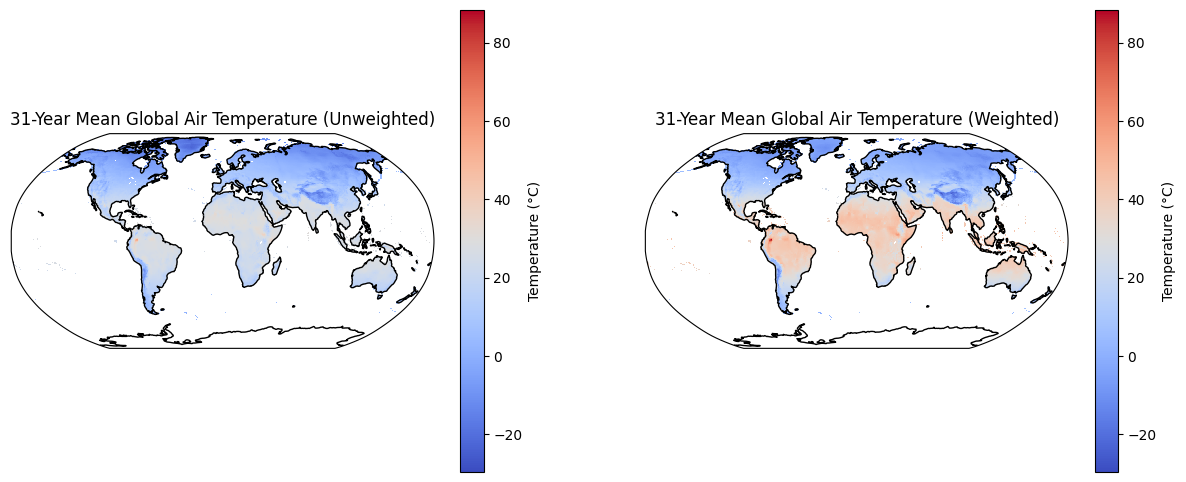

In [143]:
# compute the mean temperature maps
mean_TA_unweighted = TA.mean(dim='time')  # unweighted
mean_TA_weighted = (TA * weights).mean(dim='time') / weights.mean()  # weighted

# make sure they have the same scale for the color bar
vmin = min(mean_TA_unweighted.min(), mean_TA_weighted.min())
vmax = max(mean_TA_unweighted.max(), mean_TA_weighted.max())

# plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.Robinson()})

# unweighted map
ax1 = axes[0]
im1 = mean_TA_unweighted.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='coolwarm',
                              vmin=vmin, vmax=vmax, add_colorbar=False)
ax1.set_title('31-Year Mean Global Air Temperature (Unweighted)')
ax1.coastlines()

# add color bar
cbar1 = plt.colorbar(im1, ax=ax1, orientation='vertical', pad=0.05, aspect=20)
cbar1.set_label('Temperature (°C)')

# weighted map
ax2 = axes[1]
im2 = mean_TA_weighted.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm',
                            vmin=vmin, vmax=vmax, add_colorbar=False)
ax2.set_title('31-Year Mean Global Air Temperature (Weighted)')
ax2.coastlines()

# add color bar
cbar2 = plt.colorbar(im2, ax=ax2, orientation='vertical', pad=0.05, aspect=20)
cbar2.set_label('Temperature (°C)')

plt.show()